In [1]:
!pip install --upgrade pip setuptools wheel --quiet
!pip install xgboost shap lime lofo-importance --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lime]


***Imports***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
import shap
import lime.lime_tabular
from lofo import LOFOImportance, Dataset

In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['smoking_history'] = le.fit_transform(df['smoking_history'])

# ***preprocess***

***Outlier removal***

In [4]:
data = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for col in data:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lw, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df = df[(df[col] >= lw) & (df[col] <= up)]


**Split & scale**

In [5]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Train XGBoost**

In [6]:
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)

#  Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_model.predict(X_test)))
print(classification_report(y_test, xgb_model.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:21:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9726186525058081
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17177
           1       0.90      0.50      0.65       901

    accuracy                           0.97     18078
   macro avg       0.94      0.75      0.82     18078
weighted avg       0.97      0.97      0.97     18078



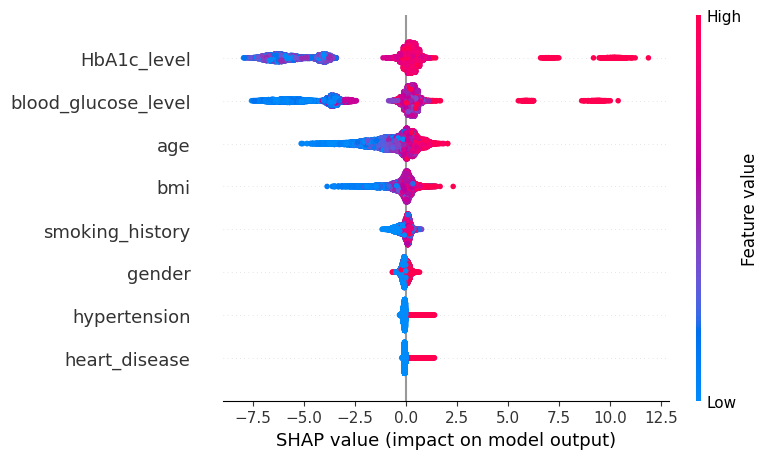

In [7]:
# SHAP summary plot
explainer_shap = shap.Explainer(xgb_model)
shap_vals = explainer_shap(X_test)
shap.summary_plot(shap_vals, features=X_test, feature_names=X.columns)

In [8]:
# LIME explanation (single instance)
lime_exp = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns.tolist(),
    class_names=['No Diabetes','Diabetes'],
    mode='classification'
)
exp = lime_exp.explain_instance(
    X_test[1], xgb_model.predict_proba, num_features=5
)
exp.show_in_notebook(show_table=True)

  0%|          | 0/8 [00:00<?, ?it/s]

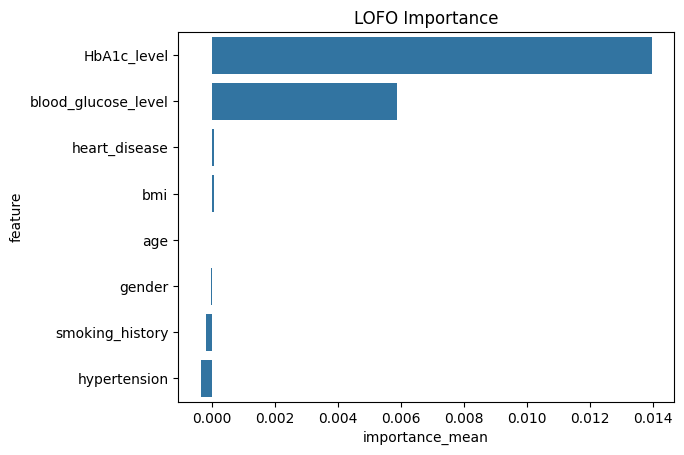

In [9]:
# LOFO with scoring
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df['target'] = y_train.values
lofo_ds = Dataset(df=train_df, target='target', features=X.columns.tolist())
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lofo_imp = LOFOImportance(
    dataset=lofo_ds,
    model=xgb_model,
    cv=cv,
    scoring='accuracy'
)
imp_df = lofo_imp.get_importance()
sns.barplot(data=imp_df, x='importance_mean', y='feature')
plt.title("LOFO Importance")
plt.show()

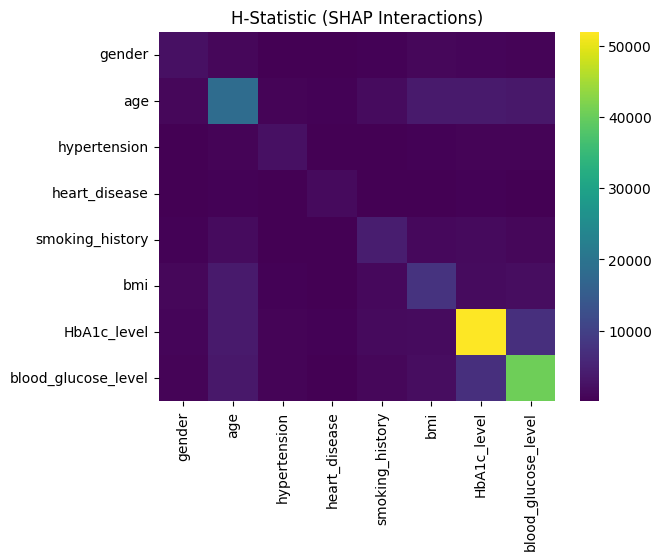

In [10]:
# H‑Statistic
interact = shap.TreeExplainer(xgb_model).shap_interaction_values(X_test)
heat_df = pd.DataFrame(
    np.abs(interact).sum(axis=0),
    index=X.columns, columns=X.columns
)
sns.heatmap(heat_df, cmap='viridis')
plt.title("H‑Statistic (SHAP Interactions)")
plt.show()